In [1]:
import utilities
import torch
import torch.nn.functional as F
from torch import nn
import dataloader
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
from code.sepconvfull import model
from collections import OrderedDict

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [10]:
def convert_subnet(subnet, kernel_size):
    
    pad = int((kernel_size - 51)/2)
    
    # change second to last layer
    W = subnet[4].weight.data
    b = subnet[4].bias.data

    subnet[4] = nn.Conv2d(64, kernel_size, 3, stride=1, padding=1)

    subnet[4].weight.data.zero_()
    subnet[4].bias.data.zero_()
    subnet[4].weight.data[pad:-pad] = W
    subnet[4].bias.data[pad:-pad] = b
    
    
    # change last layer
    b = subnet[7].bias.data
    W = subnet[7].weight.data

    subnet[7] = nn.Conv2d(kernel_size, kernel_size, 3, stride=1, padding=1)
    
    subnet[7].weight.data.zero_()
    subnet[7].bias.data.zero_()
    
    subnet[7].weight.data[pad:-pad, pad:-pad] = W
    subnet[7].bias.data[pad:-pad] = b
    
    return subnet

In [11]:
def convert_weights(weights):
    w = OrderedDict()
    for key in weights:
        new_key = 'get_kernel.'+key
        w[new_key] = weights[key]
        
    return w

def get_sepconv(input_size=2, kernel_size=51, weights='l1'):

    assert weights in ['l1', 'lf']
    
    kernel_size = 61
    assert kernel_size % 2 == 1 and kernel_size >= 51
    kernel_pad = int(math.floor(kernel_size / 2.0))
    

    sepconv = model.SepConvNet(kernel_size=51)

    weights = torch.load(f'code/sepconv/network-{weights}.pytorch')
    weights = convert_weights(weights)

    sepconv.load_state_dict(weights)
    
    
    if kernel_size > 51:
        sepconv.get_kernel.moduleVertical1 = convert_subnet(sepconv.get_kernel.moduleVertical1, kernel_size)
        sepconv.get_kernel.moduleVertical2 = convert_subnet(sepconv.get_kernel.moduleVertical2, kernel_size)
        sepconv.get_kernel.moduleHorizontal1 = convert_subnet(sepconv.get_kernel.moduleHorizontal1, kernel_size)
        sepconv.get_kernel.moduleHorizontal2 = convert_subnet(sepconv.get_kernel.moduleHorizontal2, kernel_size)

        sepconv.modulePad = torch.nn.ReplicationPad2d([kernel_pad, kernel_pad, kernel_pad, kernel_pad])
        
    
    
    
    
    
    if input_size == 4:

        # save old weights
        W = sepconv.get_kernel.moduleConv1[0].weight.data
        b = sepconv.get_kernel.moduleConv1[0].bias.data

        # change architecture (6->12 channels)
        sepconv.get_kernel.moduleConv1[0] = torch.nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)

        # replace old weights for first 6 channels, randomly init others
        sepconv.get_kernel.moduleConv1[0].weight.data.zero_()
        sepconv.get_kernel.moduleConv1[0].weight.data[:, 3:9, :, :] = W
        
        sepconv.get_kernel.moduleConv1[0].bias.data.zero_()
        sepconv.get_kernel.moduleConv1[0].bias.data = b
    
        return sepconv
    
    else:
        return sepconv

In [12]:
sepconv = get_sepconv(input_size = 4, kernel_size=61).cuda()

In [8]:
# sepconv.get_kernel.moduleVertical1 = convert_subnet(sepconv.get_kernel.moduleVertical1)
# sepconv.get_kernel.moduleVertical2 = convert_subnet(sepconv.get_kernel.moduleVertical2)
# sepconv.get_kernel.moduleHorizontal1 = convert_subnet(sepconv.get_kernel.moduleHorizontal1)
# sepconv.get_kernel.moduleHorizontal2 = convert_subnet(sepconv.get_kernel.moduleHorizontal2)

# sepconv.modulePad = torch.nn.ReplicationPad2d([kernel_pad, kernel_pad, kernel_pad, kernel_pad])

In [9]:
## test

In [14]:
dl = dataloader.adobe240_dataset(quadratic=True)
# dl = dataloader.TransformedDataset(dl, random_crop=False, h_flip_prob=0.0, v_flip_prob=0.0)
# dl = torch.utils.data.DataLoader(dl, shuffle=False)

In [15]:
X,y = dl[1]


X = X.permute(0,3,1,2).unsqueeze(0).cuda() / 255.
y = y.permute(2,0,1).unsqueeze(0).cuda()

    

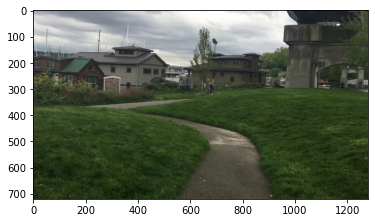

In [16]:
y_image = y.squeeze(0).permute(1,2,0).detach().cpu().int()
plt.imshow(y_image)

In [24]:
# input size 2, kernel 61
out = sepconv(X)

out.sum()

tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [17]:
# input size 4, kernel 61 - 2
out = sepconv(X)

out.sum()

tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [9]:
# input size 2, kernel 51
out = sepconv(X)

out.sum()

tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [9]:
# input size 4, kernel 51
out = sepconv(X)

out.sum()

tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [14]:
# input size 4, kernel 61
out = sepconv(X)

out.sum()

tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [7]:
# input size 4a
out = sepconv(X)

out.sum()

padded tensor(3414924., device='cuda:0')
sum tensor(3414924.2500, device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(851570.2500, device='cuda:0', grad_fn=<SumBackward0>)

In [6]:
# input size 4b
out = sepconv(X)

out.sum()

padded tensor(3414924., device='cuda:0')
sum tensor(3414924., device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [7]:
# input size 4c
out = sepconv(X)

out.sum()

padded tensor(3414924., device='cuda:0')
sum tensor(3414924., device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
#input size 2, kernel 51, C
out = sepconv(X)

out.sum()

padded tensor(1705203.7500, device='cuda:0')
sum tensor(1705203.7500, device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [7]:
#input size 2, kernel 51, A
out = sepconv(X)

out.sum()

padded tensor(1705203.7500, device='cuda:0')
sum tensor(1705203.7500, device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(847062., device='cuda:0', grad_fn=<SumBackward0>)

In [7]:
#input size 2, kernel 51, B
out = sepconv(X)

out.sum()

padded tensor(1705203.7500, device='cuda:0')
sum tensor(1705203.7500, device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [13]:
# input size 2, kernel 61, C
out = sepconv(X)

out.sum()

padded tensor(1705203.7500, device='cuda:0')
sum tensor(1705203.7500, device='cuda:0')
tc torch.Size([1, 64, 368, 640])


tensor(853098.8125, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
out_image = out.squeeze().permute(1,2,0).clamp(0,1).mul(255).int().detach().cpu()

y_image = y.squeeze(0).permute(1,2,0).detach().cpu().int()

Text(0.5, 1.0, 'label')

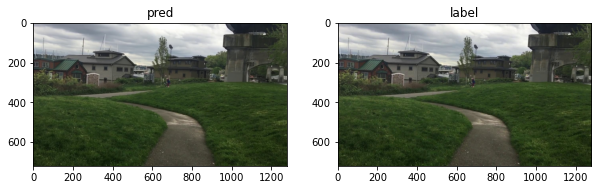

In [9]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(out_image)
ax1.set_title('pred')
ax2.imshow(y_image)
ax2.set_title('label')

In [28]:
im1 = torch.randn(1,3,100,200)
im2 = torch.randn(1,3,100,200)
im3 = torch.randn(1,3,100,200)
im4 = torch.randn(1,3,100,200)

In [29]:
R1 = torch.cat([im1, im2, im3, im4], 1)
R1.shape

torch.Size([1, 12, 100, 200])

In [30]:
torch.stack([im1, im2, im3, im4], 1).shape

torch.Size([1, 4, 3, 100, 200])

In [34]:
(torch.stack([im1, im2, im3,  im4], 1).view(1, 12, 100, 200).contiguous() == R1).all()

tensor(True)

In [14]:
M = torch.randint(10, (1,2,3,4)); M

tensor([[[[1, 7, 1, 4],
          [2, 3, 7, 7],
          [6, 3, 2, 0]],

         [[7, 2, 8, 1],
          [1, 7, 1, 9],
          [6, 4, 9, 4]]]])

In [22]:
M[:,1,:,:]

tensor([[[7, 2, 8, 1],
         [1, 7, 1, 9],
         [6, 4, 9, 4]]])

In [16]:
Mv = M.view(1, 6, 4)

In [21]:
Mv[0,3:, :]

tensor([[7, 2, 8, 1],
        [1, 7, 1, 9],
        [6, 4, 9, 4]])